# Detecting Fraud transactions

First, I install gdown which helps in downloading the file from google drive.

In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,roc_auc_score
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
gdown.download("https://drive.google.com/uc?export=download&confirm=6gh6&id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=6gh6&id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV
To: /kaggle/working/Fraud.csv
100%|██████████| 494M/494M [00:04<00:00, 112MB/s]


'Fraud.csv'

In [4]:
fraud=pd.read_csv("/kaggle/working/Fraud.csv")

In [5]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Now as mentioned in the data dictionary, this is a time series data and the step column represents the time. I try to explore the data to come to some conclusions about it.

First, I check if the data contains any NULL values or not. As the following cell shows, the data doesn't contain any NULL values.

In [6]:
fraud.isnull().any().any()

False

Now as mentioned in the data dictionary, the letters C and M in the 'nameOrig' and 'nameDest' column indicate the type of customer from which the transaction is originating and is destined for respectively.
As the following Cell shows, all transactions in this data originate from customers only.

In [7]:
np.unique(np.array([x[0] for x in fraud['nameOrig']]))

array(['C'], dtype='<U1')

However, transactions in this data are destined for both Customers and Merchants.

In [8]:
np.unique(np.array([x[0] for x in fraud['nameDest']]))

array(['C', 'M'], dtype='<U1')

In [9]:
np.unique(fraud['type'])

array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
      dtype=object)

Now,as the above cell shows, there are 5 different types of transactions in this dataset. Some types could have a higher correlation fraud compared to other types. It makes sense to do a one-hot encoding of this Column and add that to the dataset and then drop this column, which is done in the preprocessing function in the cell below.

Also, since the 'nameOrig' column contains customers of a single type, it make sense to remove the prefix letter from the 'nameOrig' column and just retain the number. The 'nameDest' column contains customers of both types, so I create a new column named 'Desttype' containing the destination customer type. At the same time,I also removing the prefix indicating the customer type in the 'nameDest' column. And at last, I one-hot encode the new column 'Desttype' as it contains categorical values from two different categories and add it to the dataset while ultimately dropping the 'type' and 'Desttype' columns as the data they contain is already available in other columns.  All this is implemented via the preprocessing function defined in the cell below.

In [10]:
def preprocessing(df):
    df['nameOrig']=np.array([x[1:] for x in df['nameOrig']]).astype(np.int64) #removing the prefix letter C indicating customer type from 'nameOrig' column
    df['Desttype']=[x[0] for x in df['nameDest']] #extracting the prefix letter indicating customer type from the 'nameDest' column and creating a new column
    df['nameDest']=np.array([x[1:] for x in df['nameDest']]).astype(np.int64) #extracting the prefix letter indicating customer type from the 'nameDest' column
    dummies=pd.get_dummies(df,columns=['type','Desttype']) #one-hot-encoding 
    for column in dummies.columns:
        df[column]=dummies[column]
    df=df.drop(['type','Desttype'],axis=1) 
    return df

In [11]:
fraud=preprocessing(fraud)

In [12]:
fraud.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Desttype_C,Desttype_M
0,1,9839.64,1231006815,170136.0,160296.36,1979787155,0.0,0.0,0,0,0,0,0,1,0,0,1
1,1,1864.28,1666544295,21249.0,19384.72,2044282225,0.0,0.0,0,0,0,0,0,1,0,0,1
2,1,181.00,1305486145,181.0,0.00,553264065,0.0,0.0,1,0,0,0,0,0,1,1,0
3,1,181.00,840083671,181.0,0.00,38997010,21182.0,0.0,1,0,0,1,0,0,0,1,0
4,1,11668.14,2048537720,41554.0,29885.86,1230701703,0.0,0.0,0,0,0,0,0,1,0,0,1


As it can be seen above, we have a much cleaner dataset.

Now, I try and analyse whether the system is currently able to flag fraud transactions efficiently or not.

In [13]:
fraud_transactions=fraud.loc[fraud["isFraud"]==1]
fraud_and_flagged_fraud_transactions=fraud_transactions.loc[fraud_transactions["isFlaggedFraud"]==1]
fraud_and_not_flagged_fraud_transactions=fraud_transactions.loc[fraud_transactions["isFlaggedFraud"]==0]
false_flags=fraud.loc[fraud["isFlaggedFraud"]==1].loc[fraud["isFraud"]==0]
print("No. of fraud transactions: ",len(fraud_transactions),
      "\nNo. of fraud transactions which were flagged fraud: ",len(fraud_and_flagged_fraud_transactions),
      "\n No. of fraud transactions which were not flagged fraud: ",len(fraud_and_not_flagged_fraud_transactions),
      "\n No. of genuine transactions which were falsely flagged fraud : ",len(false_flags))

No. of fraud transactions:  8213 
No. of fraud transactions which were flagged fraud:  16 
 No. of fraud transactions which were not flagged fraud:  8197 
 No. of genuine transactions which were falsely flagged fraud :  0


So, here lies the problem. The fraud detection algorithms in place are not all accurate enough to detect the fraud transactions. As it can be observed from the above cell that the fraud detection algorithm can only detect 16 out 8213 fraud transactions.

To check correlation among the columns, I plot the correlation matrix.

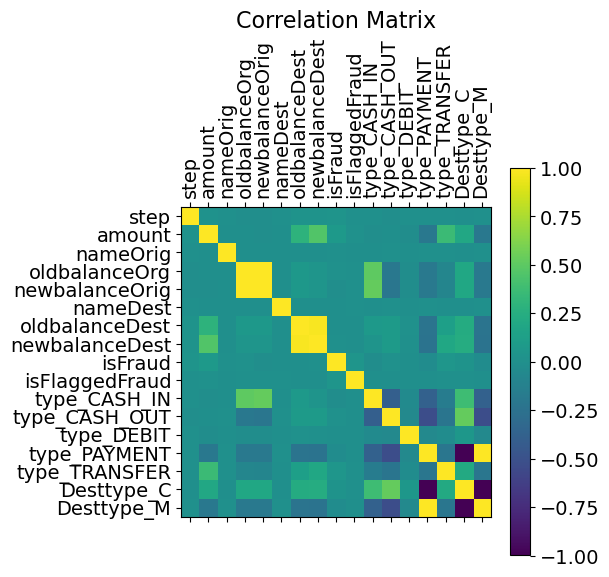

In [14]:
f=plt.figure(figsize=(5,5))
plt.matshow(fraud.corr(numeric_only=False),fignum=f.number)
plt.xticks(range(fraud.select_dtypes(['number','object']).shape[1]),fraud.select_dtypes(['number','object']).columns,fontsize=14,rotation=90)
plt.yticks(range(fraud.select_dtypes(['number','object']).shape[1]),fraud.select_dtypes(['number','object']).columns,fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix',fontsize=16);

From here it can be seen that newbalanceOrig and oldbalanceOrig columns have very high correlation(Almost 1). So,dropping one of these makes sense. I will be dropping the newbalanceOrig column. There is not much clear and useful info here apart from this,so, I check the correlation coefficients of the columns with the 'isFraud' column only to gather some detailed insight.

In [15]:
fraud.corr(numeric_only=False)["isFraud"].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
isFlaggedFraud    0.044109
step              0.031578
Desttype_C        0.025697
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
nameOrig          0.000470
nameDest         -0.000141
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_CASH_IN     -0.019089
type_PAYMENT     -0.025697
Desttype_M       -0.025697
Name: isFraud, dtype: float64

Upon taking a look at the coefficients above,some conclusions can be made:- 

1.The amount of transaction is a  key factor in behind whether a transaction is fraud or not. 

2.Also,TRANSFER and CASH_OUT transactions are relatively more likely to be fraud than other kinds of transactions. 

3.Most fraud transactions have a destination customer of type 'C', and transactions destined for merchants are very less likely to be fraud. 

4.The higher the initial balance in the origin account before the transaction,more is the chances of it being susceptible to a fraud transaction.This completely makes sense as scammers are more likely to target higher value accounts.

5.The time when the transaction occurs is also marginally related to the chances of the transaction being fraud.

6.The balance in the destination account is marginally positively related to the possibilty of a transaction being fraud.

7.The name of the customer from which the transaction originates is also marginally positively related to the possibilty of a transaction being fraud.

Most of these observations make sense except for maybe observation no. 7.

Now,both the name columns are not exactly numerical columns but they are rather categorical columns as they represent individual customer names. Now as shown in the cell below, the no. of such names is very high.

In [16]:
len(np.unique(fraud['nameOrig']+fraud['nameDest']))

6356312

Encoding these many names in order to feed it to the dataset does not sound rational as the correlation coefficient of 'nameOrig' is just 0.000470 and that of 'nameDest' is an even lower -0.025697.  It makes more sense to drop these columns before feeding the data to the model. This is done in final_split_data() function in the below cell which also performs Min-Max scaling on the data, which is entirely numerical at this point.

In the function, The 'isFlaggedFraud' column is also dropped as it doesn't contribute much in determining whether the transaction is fraud or not as the flagging algorithm is very weak.Also, I aim to make the model independent of time in order to have a more robust model so the time indicator column named 'step' is also dropped. 

Also,the function splits the data into train and test sets and returns it. #Since, this is time series data, special care is taken to ensure that data is split along the time dimension. The train set contains the first 50% length of the data,and the remaining 50% is in the test set.#

In [17]:
def final_split_data(df):
    df=df.drop(["nameOrig","nameDest","newbalanceOrig","isFlaggedFraud","step"],axis=1)
    df=(df-df.min())/(df.max()-df.min()+1e-16) #min_max_scaling
    X,y=df.drop(["isFraud"],axis=1),df["isFraud"]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=42)
    return(X_train,X_test,y_train,y_test)

In [18]:
X_train,X_test,y_train,y_test=final_split_data(fraud)

In [19]:
X_train.head()

,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Desttype_C,Desttype_M
2408104,0.000290,0.000462,0.020155,0.020071,1.0,0.0,0.0,0.0,0.0,1.0,0.0
662430,0.003731,0.000000,0.010482,0.011446,0.0,1.0,0.0,0.0,0.0,1.0,0.0
496595,0.020148,0.000000,0.009353,0.013795,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5053741,0.000408,0.001119,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
755621,0.004068,0.000378,0.000512,0.001568,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Now, it will be a good idea to free up some RAM by deleting the variables which are no longer needed.

In [20]:
del fraud,fraud_transactions,fraud_and_flagged_fraud_transactions,fraud_and_not_flagged_fraud_transactions,false_flags
gc.collect()

67

Now,I check the balance of the dataset. As the below cell shows, the train set is highly imbalanced in favour of the Genuine transactions, which is not surprising as Fraud transactions are much less common than Genuine Transactions.

In [21]:
fig=go.Figure(data=[go.Pie(labels=['Genuine','Fraud'], values=y_train.value_counts())])
fig.show()

To Counter this imbalance, I use Over-Sampling to balance the train set.

In [22]:
sm=SMOTE(random_state=42)
X_train,y_train=sm.fit_resample(X_train,y_train)
fig=go.Figure(data=[go.Pie(labels=['Genuine','Fraud'],values=y_train.value_counts())])
fig.show()

Now, that the train set is balanced and as this dataset is tabular in addition to the fact task at hand is to detect fraud transactions,my previous experience with these kind of tasks says that tree based classifiers should perform well in this scenario. I try a RandomForestClassifier.

In [23]:
clf=RandomForestClassifier(50,n_jobs=-1,verbose=1)

In [24]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.2min finished


RandomForestClassifier(n_estimators=50, n_jobs=-1, verbose=1)

In [25]:
pred=clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.7s finished


In [26]:
accuracy_score(y_test,pred)

0.9987746138121298

It performs well with a 99.98% accuracy on the test set.However,accuracy is not a good metric here as in the test set fraud transactions are much rarer than genuine transactions. Checking the confusion matrix will be better. 

In [27]:
cm=confusion_matrix(y_test,pred)
print(cm)

[[1904327    2024]
 [    315    2120]]


As it can be seen from the confusion matrix, the model correctly detects 2109 Fraud transactions and misses out on 326 Fraud transactions in the test set. It also falsely flags 1873 genuine transactions as Fraud but it is just a miniscule percentage of all genuine transactions.

In [28]:
print("Fraud Detection percentage: ","{:.4f}".format(cm[1][1]/(cm[1][0]+cm[1][1])*100,"%"))
print("False Flag percentage: ","{:.4f}".format(cm[0][1]/(cm[0][0]+cm[0][1])*100,"%"))

Fraud Detection percentage:  87.0637
False Flag percentage:  0.1062


In [29]:
roc_auc_score(y_test,pred)

0.9347874180348272

However, if the inference is done in a probabilistic approach by setting the threshold at 37% probability as done below, the results are slightly better.

In [30]:
def probabilistic_inference(clf,X_test):
    pred_proba=clf.predict_proba(X_test)
    pred_proba=[(1 if x[1]>=0.37 else 0) for x in pred_proba]
    return(pred_proba)

In [31]:
cm=confusion_matrix(y_test,probabilistic_inference(clf,X_test))
print(cm)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.2s finished


[[1900914    5437]
 [    206    2229]]


In [32]:
print("Fraud Detection percentage: ","{:.4f}".format(cm[1][1]/(cm[1][0]+cm[1][1])*100),"%")
print("False Flag percentage: ","{:.4f}".format(cm[0][1]/(cm[0][0]+cm[0][1])*100),"%")

Fraud Detection percentage:  91.5400 %
False Flag percentage:  0.2852 %


Here, the no. of false flags goes up slightly, but the no. of fraud transactions detected is now more than 89%. So, inferencing the model this way is a better option.

In [33]:
clf.feature_importances_

array([0.22720452, 0.22721453, 0.04439751, 0.08467471, 0.07917614,
       0.05556635, 0.00107568, 0.0484996 , 0.12679264, 0.0426228 ,
       0.06277552])

Thus, the first two features,i.e, amount and oldbalanceOrig are the primary factors in predicting fradulent customers. Also, the Transfer and Cashout transaction types are also quite significant. Now,based on this,I do some conclusionary data analysis to come up with a temporary solution while the company upgrades the infrastructure to deploy the new model.

In [34]:
fraud1=pd.read_csv("/kaggle/working/Fraud.csv",usecols=["amount","isFraud","oldbalanceOrg","type"])

In [35]:
fraud1.head()

,type,amount,oldbalanceOrg,isFraud
0,PAYMENT,9839.64,170136.0,0
1,PAYMENT,1864.28,21249.0,0
2,TRANSFER,181.00,181.0,1
3,CASH_OUT,181.00,181.0,1
4,PAYMENT,11668.14,41554.0,0


In [36]:
payment_type=fraud1['type']
amounts=fraud1['amount']
oldbalanceOrig=fraud1['oldbalanceOrg']
is_fraud=fraud1['isFraud']

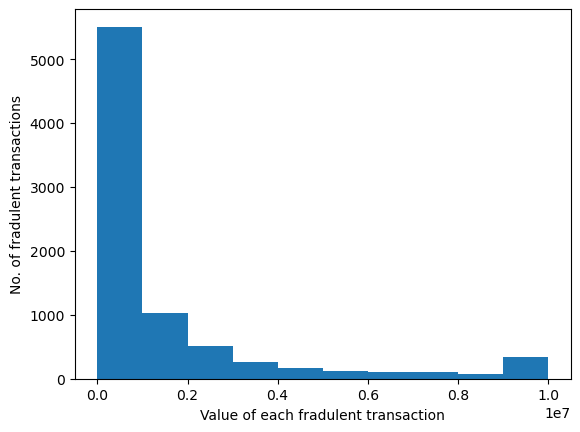

In [37]:
fradulent_amounts=[]
for i in [index for index,value in enumerate(is_fraud) if value == 1]:
    fradulent_amounts+=[amounts[i]]
plt.hist(fradulent_amounts)
plt.xlabel("Value of each fradulent transaction")
plt.ylabel("No. of fradulent transactions")
plt.show()

The above histogram doesn't say much apart from the fact the most fradulent transactions are in the range 0-1e+7. However, there are a significant no. of very high value fradulent transactions as well,which can't be ignored.

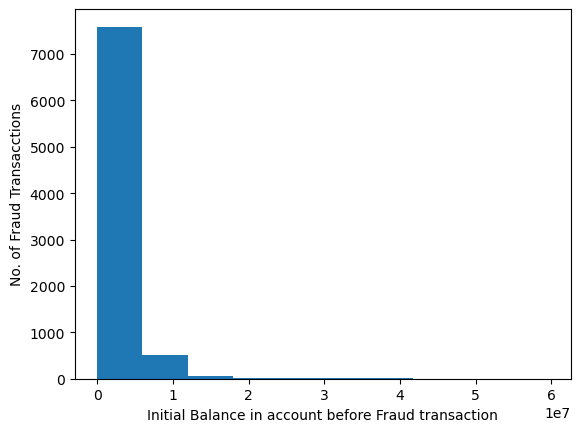

In [38]:
fradulent_old_balances=[]
for i in [index for index,value in enumerate(is_fraud) if value == 1]:
    fradulent_old_balances+=[oldbalanceOrig[i]]
plt.hist(fradulent_old_balances)
plt.xlabel("Initial Balance in account before Fraud transaction")
plt.ylabel("No. of Fraud Transacctions")
plt.show()

Now the above plot does make one thing very clear is that fraudsters are more likely to target accounts where the initial balance is in the range 0-2e+7. However, a very miniscule number of accounts having higher initial balances have been targeted as well.

{'TRANSFER': 4097, 'CASH_OUT': 4116}


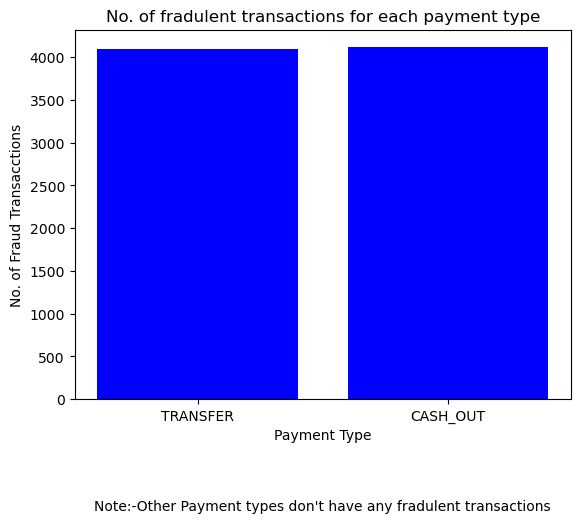

In [39]:
def count_fraud_by_category(payment_type,is_fraud):
    fraud_by_category={}
    for category,fraud_status in zip(payment_type,is_fraud):
        if fraud_status==1:
            fraud_by_category[category]=fraud_by_category.get(category,0)+1
    return fraud_by_category
fraud_by_category=count_fraud_by_category(payment_type,is_fraud)
print(fraud_by_category)
categories=list(fraud_by_category.keys())
fraud_counts=list(fraud_by_category.values())
plt.bar(categories, fraud_counts, color='blue')
plt.xlabel("Payment Type")
plt.ylabel("No. of Fraud Transacctions")
plt.title("No. of fradulent transactions for each payment type")
plt.text(0.5,-0.3,"Note:-Other Payment types don't have any fradulent transactions",
        transform=plt.gca().transAxes, fontsize=10, ha='center')
plt.xticks(rotation=0)
plt.show()

Now, it becomes clear that fradulent transactions are either Transfer or Cash_out.So some preventive measures can be taken.

**Preventive Measures**

1.Temporarily the best solution will be to add a security feature like an OTP as a verification step for these transaction types in order to have an extra layer of security.This will help in reducing fraud instances where fraudsters gain access to bank accounts and transfer or cash out the funds.

2.Also, temporarily putting a daily limit on the amount that can be CASH_OUT until the infrastructure is updated is another option. This way, if a fraud transaction does occur, the losses to the customer can be minimized. However, this does come at the cost of inconvenience to some customers. 

3.In the longer term, biometric verfication for digital transactions can be introduced as an optional feature for customers, so that customers with access to supported devices can set it up and limit ability of other people to do transactions even if they do get access. 

4.And,once the model is deployed, the inference must be done in the probabilistic way with a threshold of 37%. Then,while transactions,If the probability of fraud turn out to be above 37%, then the user must be immediately notified and prompted with an alert to review the transaction before continuing and a verification request.

**Verification of these preventive measures**


1.To verify whether the preventive measures work, monitoring for a couple of days is a good option. 

2.However,for quick conclusions simulated testing of these methods can be carried out to ensure functionality and efficiency of the methods.